# GANomaly
- 2020.08.16 : gen 10 / lr 3e-2

# 개발일지
- 2020.08.15 : 분율 추출 구현 / 이상치 상관계수 추출 구현 / 모델 save, load 구현
- 2020.08.16 : anomaly detect 이미지 저장 구현 / 티타늄(Ti64) 상대 밀도 계산 구현

--- 

# Module

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Hyper Parameter

In [2]:
latent_size = 100  # z벡터의 잠재공간(latent space)의 크기
workers = 4    # 0일때, 약 20% 사용 4일 경우 메모리 100%
img_size = 64
channel = 1
epochs = 100
batch_size = 64
learning_rate = 3e-2

# Data and Device

In [3]:
# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
#data_root = "../../dataset/train"
DP_aug_data_root = "../../dataset/aug_train/aug_DualPhaseSteel"

data_set = dataset.ImageFolder(root = DP_aug_data_root, # data_root,
                           transform = transforms.Compose([
                                  #transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

print("size of dataset :", len(data_set))

# 배치로 나누고 셔플하기
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device :", device)

size of dataset : 990
device : cuda:0


# MODEL

In [4]:
# GANomaly : Generative Adversarial Networks Model using Decoder with AutoEncoder

# === Decoder 모델 ===
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        # Batch Normalization 유무에 따른 G_block 정의
        def DC_conv_block(in_features, out_features):
            block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
            ]
            return block
        
        def DC_deconv_block(in_features, out_features, FIRST=True):
            if FIRST:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 1, 0, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            return block
        
        
        # ======================= 픽셀 분포 생성 layer ======================= 
        self.DC_gen_distribution = nn.Sequential(
            # ------ input is latent_size 100 ------ 
            *DC_deconv_block(latent_size, img_size*8, FIRST=True),
            # ------ state size is 512x4x4 ------ 
            *DC_conv_block(img_size*8, img_size*8),
            # ------ state size is 512x4x4 ------   
            *DC_deconv_block(img_size*8, img_size*4, FIRST=False),
            # ------ state size is 256x8x8 ------ 
            *DC_conv_block(img_size*4, img_size*4),
            # ------ state size is 256x8x8 ------ 
            *DC_deconv_block(img_size*4, img_size*2, FIRST=False),
            # ------ state size is 128x16x16 ------ 
            *DC_conv_block(img_size*2, img_size*2),
            # ------ state size is 128x16x16 ------ 
            *DC_deconv_block(img_size*2, img_size, FIRST=False),
        )
        
        # =================== 가짜 이미지 생성 layer =================== 
        self.DC_gen_fake_img = nn.Sequential(
            # ------ state size is 64x32x32 ------ 
            nn.ConvTranspose2d(img_size, 1, 4, 2, 1, bias=False),
            nn.Tanh() # 픽셀값의 범위 : -1 ~ 1로 두기 위해서
            # ------ state size is 1x64x64 ------ 
        )
    
    def forward(self, input):
        distribution = self.DC_gen_distribution(input)
        fake_img = self.DC_gen_fake_img(distribution)
        
        return fake_img


# === Discriminator 모델 ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Batch Normalization 유무에 따른 D_block 정의
        def D_block(in_features, out_features, MP=True):
            if MP:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU(),
                    nn.MaxPool2d(2)
                ]
            return block
        
        # ============== Feature 추출 layer ==============
        self.D_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *D_block(channel, img_size, MP=False),
            # ------ input is 64 x 64 x 64 ------ 
            *D_block(img_size, img_size, MP=True),
            # ------ state is 64 x 32 x 32 ------ 
            *D_block(img_size, img_size*2, MP=False),
            # ------ state is 128 x 32 x 32 ------ 
            *D_block(img_size*2, img_size*2, MP=True),
            # ------ state is 128 x 16 x 16 ------ 
            *D_block(img_size*2, img_size*4, MP=False),
            # ------ state is 256 x 16 x 16 ------ 
            *D_block(img_size*4, img_size*4, MP=True),
            # ------ state is 256 x 8 x 8 ------ 
            *D_block(img_size*4, img_size*8, MP=False),
            # ------ state is 512 x 8 x 8 ------ 
            *D_block(img_size*8, img_size*8, MP=True),
        )
        
        # ===================== 이진 분류 layer =====================
        self.D_classification = nn.Sequential(        
            # ------- state size 512x4x4 ------- 
            nn.Conv2d(img_size*8, channel, 4, 1, 0, bias=False),
            #nn.Linear(fms*8*4*4, 1, bias=False),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        feature = self.D_extract_feature(input)
        classification = self.D_classification(feature)
        
        return classification, feature 


# === Encoder Model ===
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        def EC_block(in_features, out_features, MP=True):
            if MP:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU(),
                    nn.MaxPool2d(2)
                ]
            return block
        
        # ============== Feature 추출 ==============
        self.EC_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *EC_block(channel, img_size, MP=False),
            # ------ input is 64 x 64 x 64 ------ 
            *EC_block(img_size, img_size, MP=True),
            # ------ state is 64 x 32 x 32 ------ 
            *EC_block(img_size, img_size*2, MP=False),
            # ------ state is 128 x 32 x 32 ------ 
            *EC_block(img_size*2, img_size*2, MP=True),
            # ------ state is 128 x 16 x 16 ------ 
            *EC_block(img_size*2, img_size*4, MP=False),
            # ------ state is 256 x 16 x 16 ------ 
            *EC_block(img_size*4, img_size*4, MP=True),
            # ------ state is 256 x 8 x 8 ------ 
            *EC_block(img_size*4, img_size*8, MP=False),
            # ------ state is 512 x 8 x 8 ------ 
            *EC_block(img_size*8, img_size*8, MP=True),
        )
        
        # =============== Encoder Training layer ===============
        self.EC_validate = nn.Sequential(
            # -------state is 512 x 4 x 4-------
            nn.Conv2d(img_size*8, latent_size, 4, 1, 0, bias=False),
            nn.Tanh()
            # -------state is 100 x 97 x 97-------
        )
        
    def forward(self, input):
        feature = self.EC_extract_feature(input)
        validity = self.EC_validate(feature)
        
        return validity

# Loss & Optim

In [5]:
# DC and D 무게 초기화, classname 에 찾는 name가 없다면 -1 ,
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# D,DC,EC 네트워크 모델 객체 선언
D = Discriminator().to(device)
DC = Decoder().to(device)
EC = Encoder().to(device)

# weight initialize/ nn.Module 클래스 안에 apply 함수가 정의되 있음, 각 함수들에 다 적용 하게한다
D.apply(weights_init)
DC.apply(weights_init)
EC.apply(weights_init)

# Binary cross entropy loss and optimizer
DCGAN_criterion = nn.BCELoss()
AE_criterion = nn.MSELoss()

# latent vector에 배치 사이즈 64를 적용
# 학습한 DC로 새로운 것 만들어서 결과 확인 할때 사용
noise_z = torch.randn(img_size, latent_size, 1, 1, device = device)

# D와 DC에 대해 두가지 최적화 설정
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5,0.999))
DC_optimizer = torch.optim.Adam(DC.parameters(), lr = learning_rate, betas=(0.5,0.999))
EC_optimizer = torch.optim.Adam(EC.parameters(), lr = learning_rate, betas=(0.5,0.999))

#print(D)
#print(DC)
#print(EC)

def reset_grad():
    D_optimizer.zero_grad()
    DC_optimizer.zero_grad()

---

# Train DCGAN

In [6]:
img_list = []
DC_losses = []
D_losses = []
iters = 0

def train_DCGAN(epoch, learning_DC_per_D = 4):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        # Train D
        real_img = data[0].to(device) # image size: 64x1x64x64(batch, channel, width, height)
        b_size = real_img.size(0) # b_size = 64
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)
        
        # (--------------------------real-----------------------------)
        real_classification, _ = D(real_img) # output = D(x)
        real_loss = DCGAN_criterion(real_classification, real_labels) # D(x)=1일 때의 loss
        real_score = real_classification
        D_x = real_score.mean().item() 
            
        # (--------------------------fake-----------------------------)
        z = torch.randn(b_size, latent_size, 1, 1).to(device) # z size :64x100x1x1
        fake_img = DC(z)
        fake_classification, _ = D(fake_img) # output = D(DC(z))
        fake_loss = DCGAN_criterion(fake_classification, fake_labels) # D(DC(z))=0일 때의 loss
        fake_score = fake_classification
        D_DC_z1 = fake_score.mean().item()

        # (------------------Backprop and optimize---------------------)
        D_loss = real_loss + fake_loss
        reset_grad()
        D_loss.backward()
        D_optimizer.step() # D(x)=1, D(DC(z))=0이어야 D가 최적

        
        # Train DC
        #z = torch.randn(b_size,latent_size,1,1,device=device) # z size :64x100x1x1
        for k in range(learning_DC_per_D):
            fake_img = DC(z)
            fake_classification,_ = D(fake_img)  # output : D(DC(z))
            D_DC_z2 = fake_classification.mean().item()
            DC_loss = DCGAN_criterion(fake_classification, real_labels) # D(DC(z))=1일 때의 loss=log(D(DC(z)))

            # (------------------Backprop and optimize---------------------)
            reset_grad()
            DC_loss.backward()
            DC_optimizer.step() # D(DC(z))=1 이어야 DC가 최적
            # ==> D(DC(z))의 값이 0.5로 수렴해야 한다.
        
        
        # print
        print('[%d/%d][%d/%d]\n- D_loss : %.4f / DC_loss : %.4f\n- D(x):%.4f / D(DC(z1)) : %.4f / D(DC(z2)) : %.4f' 
                   %(epoch+1, epochs, i, len(data_loader),D_loss.item(),
                     DC_loss.item(),D_x,D_DC_z1,D_DC_z2))
        
        # Save Losses for plotting later
        DC_losses.append(DC_loss.item())
        D_losses.append(D_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = DC(noise_z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(E.state_dict(), 'E.ckpt')

In [7]:
for epoch in range(epochs):
    train_DCGAN(epoch, learning_DC_per_D = 10)

/home/piai/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/100][0/15]
- D_loss : 1.3852 / DC_loss : 0.0279
- D(x):0.4964 / D(DC(z1)) : 0.4957 / D(DC(z2)) : 0.9725
[1/100][1/15]
- D_loss : 3.8993 / DC_loss : 0.7364
- D(x):0.7613 / D(DC(z1)) : 0.9729 / D(DC(z2)) : 0.4789
[1/100][2/15]
- D_loss : 4.2811 / DC_loss : 0.0127
- D(x):0.0529 / D(DC(z1)) : 0.4832 / D(DC(z2)) : 0.9874
[1/100][3/15]
- D_loss : 4.4266 / DC_loss : 2.6389
- D(x):0.9583 / D(DC(z1)) : 0.9875 / D(DC(z2)) : 0.0715
[1/100][4/15]
- D_loss : 4.3687 / DC_loss : 0.1212
- D(x):0.0151 / D(DC(z1)) : 0.0742 / D(DC(z2)) : 0.8858
[1/100][5/15]
- D_loss : 2.5097 / DC_loss : 0.8253
- D(x):0.7228 / D(DC(z1)) : 0.8862 / D(DC(z2)) : 0.4382
[1/100][6/15]
- D_loss : 2.0727 / DC_loss : 0.8317
- D(x):0.4597 / D(DC(z1)) : 0.7206 / D(DC(z2)) : 0.4353
[1/100][7/15]
- D_loss : 1.6662 / DC_loss : 0.2343
- D(x):0.3401 / D(DC(z1)) : 0.4271 / D(DC(z2)) : 0.7912
[1/100][8/15]
- D_loss : 2.4765 / DC_loss : 0.9453
- D(x):0.4259 / D(DC(z1)) : 0.7928 / D(DC(z2)) : 0.3885
[1/100][9/15]
- D_loss : 1.7682 / DC_

[6/100][2/15]
- D_loss : 1.5736 / DC_loss : 9.9933
- D(x):0.6892 / D(DC(z1)) : 0.6936 / D(DC(z2)) : 0.0000
[6/100][3/15]
- D_loss : 9.9911 / DC_loss : 3.4705
- D(x):0.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0314
[6/100][4/15]
- D_loss : 3.5371 / DC_loss : 0.0000
- D(x):0.0300 / D(DC(z1)) : 0.0295 / D(DC(z2)) : 1.0000
[6/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[6/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[6/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[6/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[6/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[6/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[6/100][11/15]
- D_loss : 27.6

[11/100][3/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[11/100][4/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[11/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[11/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[11/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[11/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[11/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[11/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[11/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[11/100][12/15]
-

[16/100][3/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[16/100][4/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[16/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[16/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[16/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[16/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[16/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[16/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[16/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[16/100][12/15]
-

[21/100][3/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[21/100][4/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[21/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[21/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[21/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[21/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[21/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[21/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[21/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[21/100][12/15]
-

[26/100][3/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[26/100][4/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[26/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[26/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[26/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[26/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[26/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[26/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[26/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[26/100][12/15]
-

[31/100][3/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[31/100][4/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[31/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[31/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[31/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[31/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[31/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[31/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[31/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[31/100][12/15]
-

[36/100][3/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[36/100][4/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[36/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[36/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[36/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[36/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[36/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[36/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[36/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[36/100][12/15]
-

[41/100][3/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[41/100][4/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[41/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[41/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[41/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[41/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[41/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[41/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[41/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[41/100][12/15]
-

[46/100][3/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[46/100][4/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[46/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[46/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[46/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[46/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[46/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[46/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[46/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[46/100][12/15]
-

[51/100][3/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[51/100][4/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[51/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[51/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[51/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[51/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[51/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[51/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[51/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[51/100][12/15]
-

[56/100][3/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[56/100][4/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[56/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[56/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[56/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[56/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[56/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[56/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[56/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[56/100][12/15]
-

[61/100][3/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[61/100][4/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[61/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[61/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[61/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[61/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[61/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[61/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[61/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[61/100][12/15]
-

[66/100][3/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[66/100][4/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[66/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[66/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[66/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[66/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[66/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[66/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[66/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[66/100][12/15]
-

[71/100][3/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[71/100][4/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[71/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[71/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[71/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[71/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[71/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[71/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[71/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[71/100][12/15]
-

[76/100][3/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[76/100][4/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[76/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[76/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[76/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[76/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[76/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[76/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[76/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[76/100][12/15]
-

[81/100][3/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[81/100][4/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[81/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[81/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[81/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[81/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[81/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[81/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[81/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[81/100][12/15]
-

[86/100][3/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[86/100][4/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[86/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[86/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[86/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[86/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[86/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[86/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[86/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[86/100][12/15]
-

[91/100][3/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[91/100][4/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[91/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[91/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[91/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[91/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[91/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[91/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[91/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[91/100][12/15]
-

[96/100][3/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[96/100][4/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[96/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[96/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[96/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[96/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[96/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[96/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[96/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[96/100][12/15]
-

# Animation

In [8]:
def animate_gen_imgs():
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    
    ims=[[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

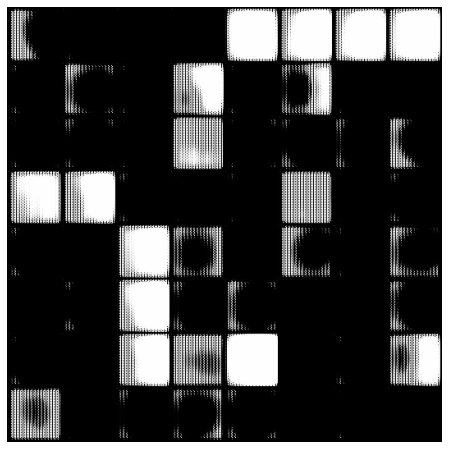

In [9]:
animate_gen_imgs()

# Trian : izif E

In [10]:
DC.eval()
D.eval()

kappa = 1.0
EC_losses = []

iters = 0
AE_img_list = []

def train_AE(epoch):
    global epochs
    global iters
    global EC_losses
    global AE_img_list
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        real_imgs = data[0].to(device)
        
        EC_optimizer.zero_grad()
        
        EC_validity = EC(real_imgs)
        
        fake_imgs = DC(EC_validity)
        
        _, real_features = D.forward(real_imgs)
        _, fake_features = D.forward(fake_imgs)
        
        
        # izif architecture
        imgs_loss = AE_criterion(real_imgs, fake_imgs)
        features_loss = AE_criterion(real_features, fake_features)
        EC_loss = imgs_loss + kappa*features_loss
        
        EC_loss.backward()
        EC_optimizer.step()
        
        # =============================================================
        # print
        # =============================================================
        print('[%d/%d][%d/%d]\n- E_loss: %.4f\n'
              %(epoch+1, epochs, i, len(data_loader), EC_loss.item()))
        
        # Save Losses for plotting later
        EC_losses.append(EC_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = DC(EC_validity).detach().cpu()
            AE_img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(E.state_dict(), 'E.ckpt')

In [11]:
for epoch in range(epochs):
    train_AE(epoch)

[1/100][0/15]
- E_loss: 1.7267

[1/100][1/15]
- E_loss: 0.6812

[1/100][2/15]
- E_loss: 0.5638

[1/100][3/15]
- E_loss: 0.6113

[1/100][4/15]
- E_loss: 0.6506

[1/100][5/15]
- E_loss: 0.5860

[1/100][6/15]
- E_loss: 0.6134

[1/100][7/15]
- E_loss: 0.7090

[1/100][8/15]
- E_loss: 0.5603

[1/100][9/15]
- E_loss: 0.6294

[1/100][10/15]
- E_loss: 0.6227

[1/100][11/15]
- E_loss: 0.6552

[1/100][12/15]
- E_loss: 0.5941

[1/100][13/15]
- E_loss: 0.5526

[1/100][14/15]
- E_loss: 0.5598

[2/100][0/15]
- E_loss: 0.6057

[2/100][1/15]
- E_loss: 0.6112

[2/100][2/15]
- E_loss: 0.6831

[2/100][3/15]
- E_loss: 0.6498

[2/100][4/15]
- E_loss: 0.6510

[2/100][5/15]
- E_loss: 0.6312

[2/100][6/15]
- E_loss: 0.5980

[2/100][7/15]
- E_loss: 0.5749

[2/100][8/15]
- E_loss: 0.5520

[2/100][9/15]
- E_loss: 0.5957

[2/100][10/15]
- E_loss: 0.6120

[2/100][11/15]
- E_loss: 0.6073

[2/100][12/15]
- E_loss: 0.6473

[2/100][13/15]
- E_loss: 0.5822

[2/100][14/15]
- E_loss: 0.5283

[3/100][0/15]
- E_loss: 0.6227

[17/100][12/15]
- E_loss: 0.6623

[17/100][13/15]
- E_loss: 0.5537

[17/100][14/15]
- E_loss: 0.5932

[18/100][0/15]
- E_loss: 0.5629

[18/100][1/15]
- E_loss: 0.6278

[18/100][2/15]
- E_loss: 0.6021

[18/100][3/15]
- E_loss: 0.6429

[18/100][4/15]
- E_loss: 0.6467

[18/100][5/15]
- E_loss: 0.5990

[18/100][6/15]
- E_loss: 0.6032

[18/100][7/15]
- E_loss: 0.5978

[18/100][8/15]
- E_loss: 0.6019

[18/100][9/15]
- E_loss: 0.5990

[18/100][10/15]
- E_loss: 0.5966

[18/100][11/15]
- E_loss: 0.5968

[18/100][12/15]
- E_loss: 0.6585

[18/100][13/15]
- E_loss: 0.5968

[18/100][14/15]
- E_loss: 0.6202

[19/100][0/15]
- E_loss: 0.6747

[19/100][1/15]
- E_loss: 0.5698

[19/100][2/15]
- E_loss: 0.5858

[19/100][3/15]
- E_loss: 0.5270

[19/100][4/15]
- E_loss: 0.6053

[19/100][5/15]
- E_loss: 0.6050

[19/100][6/15]
- E_loss: 0.6202

[19/100][7/15]
- E_loss: 0.5869

[19/100][8/15]
- E_loss: 0.6134

[19/100][9/15]
- E_loss: 0.5953

[19/100][10/15]
- E_loss: 0.6462

[19/100][11/15]
- E_loss: 0.5786



[34/100][3/15]
- E_loss: 0.5356

[34/100][4/15]
- E_loss: 0.5980

[34/100][5/15]
- E_loss: 0.5483

[34/100][6/15]
- E_loss: 0.6961

[34/100][7/15]
- E_loss: 0.5801

[34/100][8/15]
- E_loss: 0.5932

[34/100][9/15]
- E_loss: 0.6164

[34/100][10/15]
- E_loss: 0.6233

[34/100][11/15]
- E_loss: 0.6262

[34/100][12/15]
- E_loss: 0.6217

[34/100][13/15]
- E_loss: 0.6693

[34/100][14/15]
- E_loss: 0.5861

[35/100][0/15]
- E_loss: 0.6499

[35/100][1/15]
- E_loss: 0.5964

[35/100][2/15]
- E_loss: 0.5885

[35/100][3/15]
- E_loss: 0.6194

[35/100][4/15]
- E_loss: 0.6116

[35/100][5/15]
- E_loss: 0.5930

[35/100][6/15]
- E_loss: 0.6691

[35/100][7/15]
- E_loss: 0.6013

[35/100][8/15]
- E_loss: 0.6316

[35/100][9/15]
- E_loss: 0.5995

[35/100][10/15]
- E_loss: 0.5657

[35/100][11/15]
- E_loss: 0.5973

[35/100][12/15]
- E_loss: 0.6272

[35/100][13/15]
- E_loss: 0.6291

[35/100][14/15]
- E_loss: 0.5709

[36/100][0/15]
- E_loss: 0.5601

[36/100][1/15]
- E_loss: 0.6163

[36/100][2/15]
- E_loss: 0.6065



[50/100][9/15]
- E_loss: 0.5688

[50/100][10/15]
- E_loss: 0.5626

[50/100][11/15]
- E_loss: 0.6107

[50/100][12/15]
- E_loss: 0.5459

[50/100][13/15]
- E_loss: 0.5793

[50/100][14/15]
- E_loss: 0.5320

[51/100][0/15]
- E_loss: 0.5769

[51/100][1/15]
- E_loss: 0.5906

[51/100][2/15]
- E_loss: 0.6004

[51/100][3/15]
- E_loss: 0.5697

[51/100][4/15]
- E_loss: 0.6000

[51/100][5/15]
- E_loss: 0.5622

[51/100][6/15]
- E_loss: 0.5851

[51/100][7/15]
- E_loss: 0.5444

[51/100][8/15]
- E_loss: 0.5574

[51/100][9/15]
- E_loss: 0.5328

[51/100][10/15]
- E_loss: 0.5494

[51/100][11/15]
- E_loss: 0.5860

[51/100][12/15]
- E_loss: 0.5897

[51/100][13/15]
- E_loss: 0.5802

[51/100][14/15]
- E_loss: 0.5538

[52/100][0/15]
- E_loss: 0.5408

[52/100][1/15]
- E_loss: 0.5404

[52/100][2/15]
- E_loss: 0.6147

[52/100][3/15]
- E_loss: 0.5807

[52/100][4/15]
- E_loss: 0.5802

[52/100][5/15]
- E_loss: 0.5678

[52/100][6/15]
- E_loss: 0.5599

[52/100][7/15]
- E_loss: 0.5703

[52/100][8/15]
- E_loss: 0.5820



[67/100][0/15]
- E_loss: 0.5463

[67/100][1/15]
- E_loss: 0.5844

[67/100][2/15]
- E_loss: 0.5400

[67/100][3/15]
- E_loss: 0.5740

[67/100][4/15]
- E_loss: 0.5675

[67/100][5/15]
- E_loss: 0.5636

[67/100][6/15]
- E_loss: 0.5841

[67/100][7/15]
- E_loss: 0.5916

[67/100][8/15]
- E_loss: 0.5314

[67/100][9/15]
- E_loss: 0.5762

[67/100][10/15]
- E_loss: 0.5798

[67/100][11/15]
- E_loss: 0.5240

[67/100][12/15]
- E_loss: 0.5562

[67/100][13/15]
- E_loss: 0.5895

[67/100][14/15]
- E_loss: 0.6058

[68/100][0/15]
- E_loss: 0.5592

[68/100][1/15]
- E_loss: 0.5559

[68/100][2/15]
- E_loss: 0.5538

[68/100][3/15]
- E_loss: 0.5624

[68/100][4/15]
- E_loss: 0.5579

[68/100][5/15]
- E_loss: 0.5921

[68/100][6/15]
- E_loss: 0.5507

[68/100][7/15]
- E_loss: 0.5862

[68/100][8/15]
- E_loss: 0.5560

[68/100][9/15]
- E_loss: 0.5470

[68/100][10/15]
- E_loss: 0.5696

[68/100][11/15]
- E_loss: 0.5589

[68/100][12/15]
- E_loss: 0.5771

[68/100][13/15]
- E_loss: 0.6028

[68/100][14/15]
- E_loss: 0.5929



[83/100][6/15]
- E_loss: 0.5306

[83/100][7/15]
- E_loss: 0.5788

[83/100][8/15]
- E_loss: 0.5848

[83/100][9/15]
- E_loss: 0.5669

[83/100][10/15]
- E_loss: 0.6194

[83/100][11/15]
- E_loss: 0.5501

[83/100][12/15]
- E_loss: 0.6145

[83/100][13/15]
- E_loss: 0.5798

[83/100][14/15]
- E_loss: 0.5341

[84/100][0/15]
- E_loss: 0.6261

[84/100][1/15]
- E_loss: 0.5972

[84/100][2/15]
- E_loss: 0.5944

[84/100][3/15]
- E_loss: 0.6039

[84/100][4/15]
- E_loss: 0.6454

[84/100][5/15]
- E_loss: 0.5363

[84/100][6/15]
- E_loss: 0.5753

[84/100][7/15]
- E_loss: 0.5503

[84/100][8/15]
- E_loss: 0.5810

[84/100][9/15]
- E_loss: 0.5499

[84/100][10/15]
- E_loss: 0.5225

[84/100][11/15]
- E_loss: 0.5881

[84/100][12/15]
- E_loss: 0.5931

[84/100][13/15]
- E_loss: 0.5773

[84/100][14/15]
- E_loss: 0.6060

[85/100][0/15]
- E_loss: 0.5421

[85/100][1/15]
- E_loss: 0.6061

[85/100][2/15]
- E_loss: 0.5913

[85/100][3/15]
- E_loss: 0.5254

[85/100][4/15]
- E_loss: 0.5396

[85/100][5/15]
- E_loss: 0.5666



[99/100][12/15]
- E_loss: 0.6213

[99/100][13/15]
- E_loss: 0.6032

[99/100][14/15]
- E_loss: 0.5629

[100/100][0/15]
- E_loss: 0.6153

[100/100][1/15]
- E_loss: 0.5726

[100/100][2/15]
- E_loss: 0.5725

[100/100][3/15]
- E_loss: 0.5800

[100/100][4/15]
- E_loss: 0.6004

[100/100][5/15]
- E_loss: 0.6467

[100/100][6/15]
- E_loss: 0.4995

[100/100][7/15]
- E_loss: 0.5738

[100/100][8/15]
- E_loss: 0.5484

[100/100][9/15]
- E_loss: 0.6051

[100/100][10/15]
- E_loss: 0.5696

[100/100][11/15]
- E_loss: 0.5627

[100/100][12/15]
- E_loss: 0.5330

[100/100][13/15]
- E_loss: 0.5996

[100/100][14/15]
- E_loss: 0.6410



# Loss Graph

In [12]:
def plot_train_loss():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(DC_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.plot(EC_losses, label="E")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

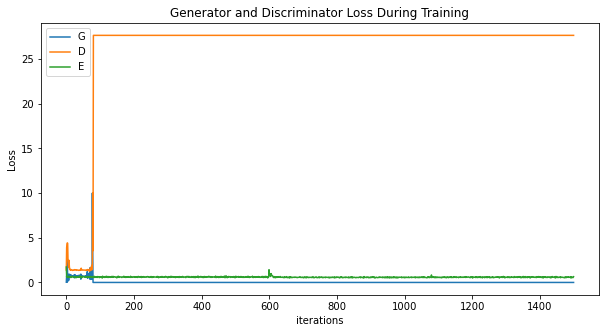

In [13]:
plot_train_loss()

---

# Test Data

In [14]:
#test_data_root = "../../dataset/test/test_DualPhaseSteel"
DP_test_data_root = "../../dataset/test/test_DualPhaseSteel"

test_data_set = dataset.ImageFolder(root = DP_test_data_root, # test_data_root,
                           transform = transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

# 배치로 나누고 셔플하기
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size = 1,
                                              shuffle = False, num_workers = workers)

# 이상 픽셀 수 확인 함수

In [15]:
def count_el_not_0(diff_img):
    count_el_not_0 = 0
    
    col_size = diff_img.shape[0]
    row_size = diff_img.shape[1]
    
    #print(col_size, row_size)
    
    for col in range(col_size):
        for row in range(row_size):
            if diff_img[col][row] != 0:
                count_el_not_0 += 1
                
    return count_el_not_0

# img 비교 함수

In [16]:
def compare_imgs(real_img, generated_img, i, score, reverse=False, threshold=50):
    real_img = real_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    
    negative = np.zeros_like(real_img)

    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img

    diff_img[diff_img <= threshold] = 0

    # 분율 추출
    diff_cnts.append(count_el_not_0(diff_img))
    # 분산 추출
    diff_points.append(np.where(diff_img > threshold))
    
    anomaly_img = np.zeros(shape=(img_size, img_size, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)

    # anomaly_img 추출
    anomaly_imgs.append(anomaly_img)
    
    fig, plots = plt.subplots(1, 4)

    fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label = "real")
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')
    plt.show()

# Test

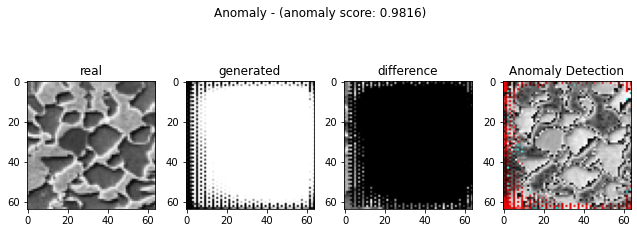

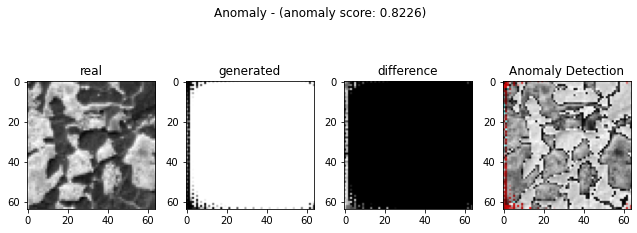

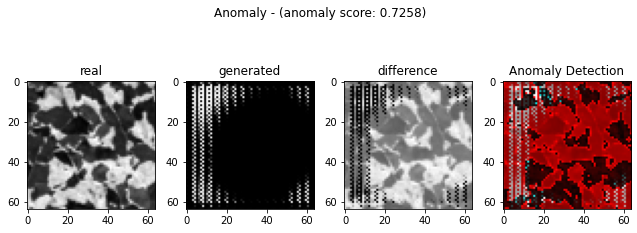

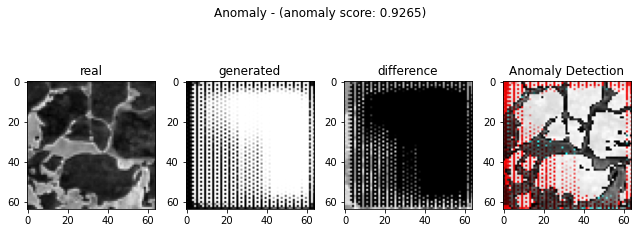

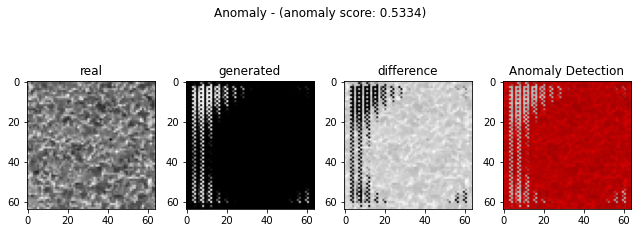

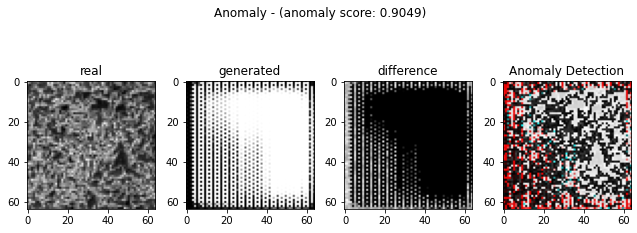

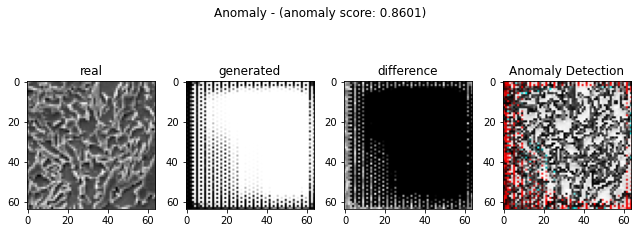

In [17]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

ano_criterion = nn.MSELoss()
DC.eval()
D.eval()
EC.eval()

# with open("score.csv", "w") as f:
#         f.write("label,img_distance,anomaly_score,z_distance\n")

for i, data in enumerate(test_data_loader, 0):
    real_img = data[0].to(device)

    real_z = EC(real_img) # 진짜 이미지의 latent vector
    fake_img = DC(real_z) # DC에 넣어서 가짜 이미지 생성.
    fake_z = EC(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

    _, real_feature = D.forward(real_img) # 1, 256
    _, fake_feature = D.forward(fake_img)

    img_distance = ano_criterion(fake_img, real_img)
    loss_feature = ano_criterion(fake_feature, real_feature)

    anomaly_score = img_distance + kappa*loss_feature

    z_distance = ano_criterion(fake_z, real_z)
    
#     with open("score.csv", "a") as f:
#             f.write(f"{label.item()},{img_distance},"
#                     f"{anomaly_score},{z_distance}\n")
            
#     print(f"{label.item()}, {img_distance}, "
#           f"{anomaly_score}, {z_distance}\n")
    compare_imgs(real_img, fake_img, i, anomaly_score, reverse = False, threshold = 0.3)

---

# 분율 추출

In [18]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.12353516 0.04492188 0.91235352 0.24462891 0.93481445 0.24389648
 0.19335938]


In [19]:
sum(diff_fraction)/len(diff_fraction)

0.38535853794642855

---

# 분산 추출

In [20]:
from scipy import stats
from extended_int import int_inf

corr_coeffis = []
corr_p_vals = []

def cal_corr_coeffis():
    for idx in range(len(test_data_loader)):
        x_points = diff_points[idx][0]
        y_points = diff_points[idx][1]
        
        
        if len(x_points) > 0:
            corr_coeffi, corr_p_val = stats.pearsonr(x_points, y_points)
        else:
            corr_coeffi, corr_p_val = -int_inf, -int_inf
        
        corr_coeffis.append(corr_coeffi)
        corr_p_vals.append(corr_p_val)

In [21]:
cal_corr_coeffis()

print(corr_coeffis)

[0.029805274010985927, 0.03389844279813724, -0.042553527488660564, 0.05701193284352235, -0.039469376521852395, 0.0500569067912226, 0.016613789476927047]


---

# 모델 저장 및 읽기

In [22]:
save_file = "./pretrained/pretrained.pth"

def save_pretrained():
    pretrained = {
        "D" : D.state_dict(),
        "DC" : DC.state_dict(),
        "EC" : EC.state_dict()
    }

    if not os.path.isdir("pretrained"):
        os.mkdir("pretrained")
    torch.save(pretrained, save_file)

In [23]:
save_pretrained()

In [24]:
pretrained_D = Discriminator().to(device)
pretrained_DC = Decoder().to(device)
pretrained_EC = Encoder().to(device)

def load_pretrained():
    global pretrained_D
    global pretrained_DC
    global pretrained_EC
    
    assert os.path.isdir("pretrained"), "Error : no pretrained dir found!"
    
    pretrained = torch.load(save_file)
    
    pretrained_D.load_state_dict(pretrained["D"])
    pretrained_DC.load_state_dict(pretrained["DC"])
    pretrained_EC.load_state_dict(pretrained["EC"])
    
    #print("pretrained_D :", pretrained_D)
    #print("pretrained_G :", pretrained_DC)
    #print("pretrained_E :", pretrained_EC)

In [25]:
load_pretrained()

In [26]:
def test():
    ano_criterion = nn.MSELoss()
    pretrained_DC.eval()
    pretrained_D.eval()
    pretrained_EC.eval()

    # with open("score.csv", "w") as f:
    #         f.write("label,img_distance,anomaly_score,z_distance\n")

    for i, data in enumerate(test_data_loader, 0):
        real_img = data[0].to(device)

        real_z = pretrained_EC(real_img) # 진짜 이미지의 latent vector
        fake_img = pretrained_DC(real_z) # DC에 넣어서 가짜 이미지 생성.
        fake_z = pretrained_EC(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

        _, real_feature = pretrained_D.forward(real_img) # 1, 256
        _, fake_feature = pretrained_D.forward(fake_img)

        img_distance = ano_criterion(fake_img, real_img)
        loss_feature = ano_criterion(fake_feature, real_feature)

        anomaly_score = img_distance + kappa*loss_feature

        z_distance = ano_criterion(fake_z, real_z)

    #     with open("score.csv", "a") as f:
    #             f.write(f"{label.item()},{img_distance},"
    #                     f"{anomaly_score},{z_distance}\n")

    #     print(f"{label.item()}, {img_distance}, "
    #           f"{anomaly_score}, {z_distance}\n")
        compare_imgs(real_img, fake_img, i, anomaly_score, reverse = False, threshold = 0.3)

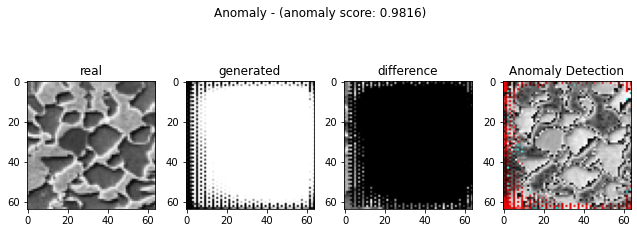

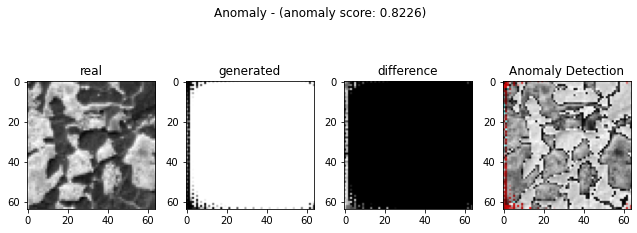

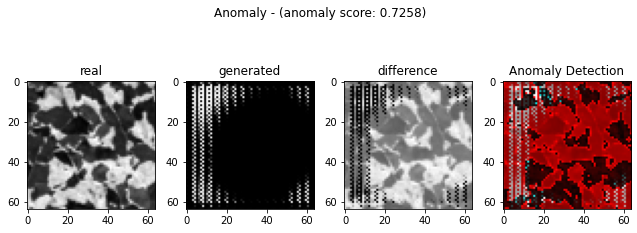

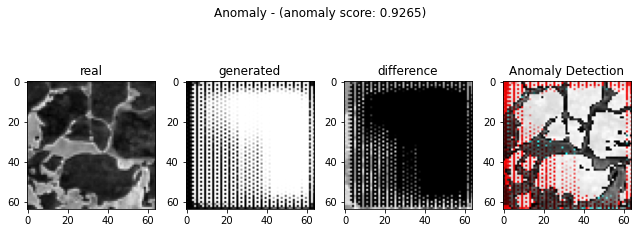

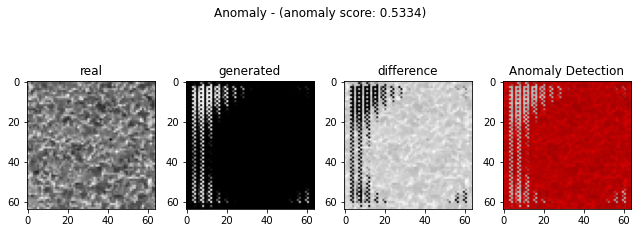

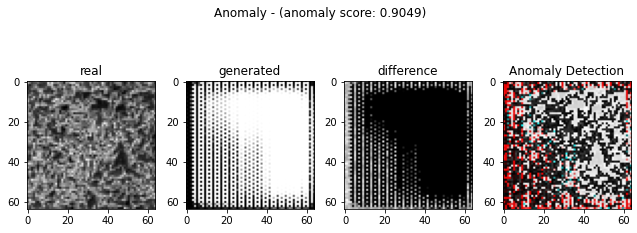

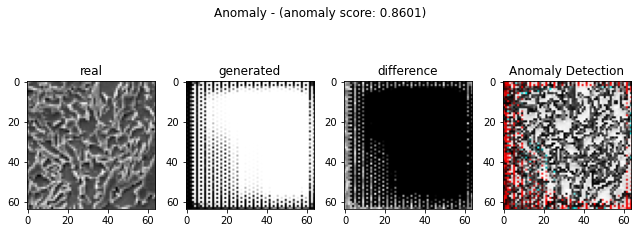

In [27]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

corr_coeffis = []
corr_p_vals = []

test()

In [28]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.12353516 0.04492188 0.91235352 0.24462891 0.93481445 0.24389648
 0.19335938]


In [29]:
cal_corr_coeffis()

print(corr_coeffis)

[0.029805274010985927, 0.03389844279813724, -0.042553527488660564, 0.05701193284352235, -0.039469376521852395, 0.0500569067912226, 0.016613789476927047]


---

# anomaly detection 이미지 추출

In [30]:
anomaly_imgs

[array([[[241, 108, 108],
         [245,   2,   2],
         [121,   4,   4],
         ...,
         [209,   2,   2],
         [176, 120, 120],
         [221,  24,  24]],
 
        [[247,   3,   3],
         [241,   1,   1],
         [ 87,   5,   5],
         ...,
         [237,   2,   2],
         [238, 238, 238],
         [189,   5,   5]],
 
        [[235,  11,  11],
         [229,   2,   2],
         [ 77,   2,   2],
         ...,
         [229,   2,   2],
         [232, 232, 232],
         [237,   6,   6]],
 
        ...,
 
        [[229,   3,   3],
         [247,   1,   1],
         [211,   3,   3],
         ...,
         [141,   2,   2],
         [ 85,  85,  85],
         [130,   4,   4]],
 
        [[227,  11,  11],
         [243,   1,   1],
         [229,   2,   2],
         ...,
         [105,   2,   2],
         [150, 150, 150],
         [251,   3,   3]],
 
        [[217,  19,  19],
         [227,   2,   2],
         [245,   8,   8],
         ...,
         [181,   2,   2],
  

# 이미지 저장 함수

In [31]:
import cv2

def save_imgs(folder, imgs):
    if not os.path.isdir("anomaly_imgs"):
        os.mkdir("anomaly_imgs")
    
    for i in range(len(imgs)):
        cv2.imwrite('%s/%d.png' %(folder,i), imgs[i]) #이미지 저장할 경로 설정을 여기서 한다.
    print("image saving complete")

In [32]:
save_imgs("./anomaly_imgs", anomaly_imgs)

image saving complete


---

# 티타늄(Ti64) 상대 밀도 계산

In [33]:
Ti64_density = 4.43

Ti64_rel_densitys = np.array([])

Ti64_rel_densitys = diff_fraction * Ti64_density

print(Ti64_rel_densitys)

[0.54726074 0.19900391 4.04172607 1.08370605 4.14122803 1.08046143
 0.85658203]
